In [2]:
from platform import python_version

print(python_version())

3.7.4


In [3]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")




INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-10-01 00:00:05+00:00
2019-10-01 08:00:05+08:00


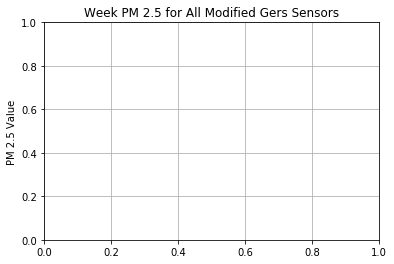

In [4]:
# all_modified_gers - This is the working boxplot for all_modified_gers only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

# Don't include sensors: FL, IA, KS, MB, NB, NJ, NL, OR, WA, WY
# Look more closely at: NE, NS

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
print(data.index[1])
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']

# Clean up data this way:
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
data['pm2_5'] = data['pm2_5'] / (1 + ((0.4/1.65)/(-1+(1/(35/100)))))
# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']

# start clean up data mode when in office or switched from outdoor to indoor or vice versa

# -------------------------- In Office ----------------------------------------------------------------------------------------------------------------------------
ak = data[data.index < '2020-02-15'].groupby("name").get_group('AK')
co = data[data.index < '2020-02-15'].groupby("name").get_group('CO')
ky = data[data.index < '2020-02-15'].groupby("name").get_group('KY')

# mb = data[data.index < '2020-02-15'].groupby("name").get_group('MB')
# mb = mb[(mb.index < '2020-01-26') | (mb.index >= '2020-02-04')]

# nj = data[(data.index < '2020-01-28') | (data.index >= '2020-02-04')].groupby("name").get_group('NJ')
nu = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('NU')
# oregon = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('OR')
pe = data[(data.index < '2020-02-11')].groupby("name").get_group('PE') #outdoor sensor we are no longer using these sensors data
# wy = data[(data.index < '2020-02-11')].groupby("name").get_group('WY') 

# --------------------------------------- Switched ---------------------------------------------------------------------------------------------------------------

ab = data[(data.index > '2020-01-28') & (data.index <= '2020-02-14')].groupby("name").get_group('AB') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ns = data[(data.index >= '2020-01-28')].groupby("name").get_group('NS') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
# oregon = oregon[(oregon.index >= '2020-01-28')] # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ut = data[(data.index >= '2020-01-29')].groupby("name").get_group('UT') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor

# finish clean up data mode when in office or switched from outdoor to indoor or vice versa
# ------------------------------------------------------------------------------------------------------------------------------------------------------

modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'ID', 'IL', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM', 'GA', 'ND', 'NE']
modified_gers_data = data[(data.name == modified_gers[0]) | (data.name == modified_gers[1]) | (data.name == modified_gers[2]) | (data.name == modified_gers[3]) | (data.name == modified_gers[4]) | (data.name == modified_gers[5]) | (data.name == modified_gers[6]) | (data.name == modified_gers[7]) | (data.name == modified_gers[8]) | (data.name == modified_gers[9]) | (data.name == modified_gers[10]) | (data.name == modified_gers[11]) | (data.name == modified_gers[12]) | (data.name == modified_gers[13]) | (data.name == modified_gers[14]) | (data.name == modified_gers[15]) | (data.name == modified_gers[16]) | (data.name == modified_gers[17]) | (data.name == modified_gers[18]) | (data.name == modified_gers[19]) | (data.name == modified_gers[20]) | (data.name == modified_gers[21])]
modified_gers_data = modified_gers_data.append(ak)
modified_gers_data = modified_gers_data.append(co)
modified_gers_data = modified_gers_data.append(ky)
# unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
# unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

unmodified_gers = ['OK', 'PA', 'RI', 'SD', 'VA', 'WI']
unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5])]
unmodified_gers_data = unmodified_gers_data.append(ab)
# unmodified_gers_data = unmodified_gers_data.append(mb)
# unmodified_gers_data = unmodified_gers_data.append(nj)
unmodified_gers_data = unmodified_gers_data.append(nu)
unmodified_gers_data = unmodified_gers_data.append(ns)
# unmodified_gers_data = unmodified_gers_data.append(oregon)
unmodified_gers_data = unmodified_gers_data.append(ut)



All Sensors names: ['AB', 'NS', 'NU', 'OK', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       ...
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday'],
      dtype='object', length=1000)
All Unmodified Gers list size: 6298362
whiskers:  [0.0, 241.47835051546392]
caps:  [0.0, 241.47835051546392]
boxes:  [12.383505154639176]
medians:  [35.381443298969074]
means:  [94.88615601491966]
fliers:  []


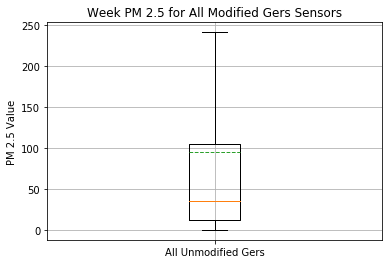

In [5]:
labels = ['All Unmodified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in unmodified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = unmodified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:1000])

all_unmodified_gers = [unmodified_gers_data.pm2_5.dropna()]
print('{} list size: {}'.format(labels[0], len(data.pm2_5.dropna())))
results = plt.boxplot(all_unmodified_gers, showfliers=False, labels=labels, showmeans=True, meanline=True)

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])



All Sensors names: ['AB', 'NS', 'NU', 'OK', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday'],
      dtype='object')
Mon list size: 185927
Tue list size: 194209
Wed list size: 192699
Thu list size: 203067
Fri list size: 198057
Sat list size: 197755
Sun list size: 194624
total for all days: 1366338

whiskers:  [0.0, 243.24742268041237, 0.0, 259.16907216494843, 0.0, 222.90309278350514, 0.0, 239.70927835051546, 0.0, 236.17113402061855, 0.0, 231.74845360824742, 0.0, 259.16907216494843]
caps:  [0.0, 243.24742268041237, 0.0, 259.16907216494843, 0.0, 222.90309278350514, 0.0, 239.70927835051546, 0.0, 236.17113402061855, 0.0, 231.74845360824742, 0.0, 259.16907216494843]
boxes:  [11.498969072164948, 12.383505154639176, 8.845360824742269, 12.383505154639176, 13.268041237113401, 13.268041237113401, 12.383505154639176]
medians:  [36.2659793814433, 36

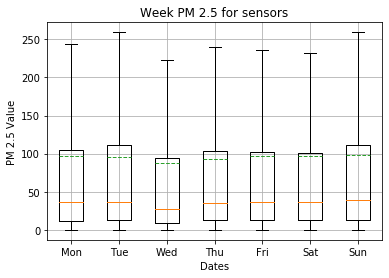

In [6]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in unmodified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = unmodified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = unmodified_gers_data[(unmodified_gers_data.index.day_name() == 'Monday')]['pm2_5'].dropna()
tuesday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Tuesday']['pm2_5'].dropna()
wednesday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Wednesday']['pm2_5'].dropna()
thursday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Thursday']['pm2_5'].dropna()
friday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Friday']['pm2_5'].dropna()
saturday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Saturday']['pm2_5'].dropna()
sunday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Sunday']['pm2_5'].dropna()
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)

i = 0
cumulative = 0
for day in all_days:
    print('{} list size: {}'.format(labels[i], len(day)))
    cumulative += len(day)
    i+= 1
print('total for all days: {}'.format(cumulative))
print()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])



All Sensors names: ['AB', 'NS', 'NU', 'OK', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday'],
      dtype='object')
Monday - AB list size: 1887
Monday - AB list size of data above 1000: 0
Monday - NS list size: 14308
Monday - NS list size of data above 1000: 0
Monday - NU list size: 13031
Monday - NU list size of data above 1000: 0
Monday - OK list size: 24216
Monday - OK list size of data above 1000: 0
Monday - PA list size: 24477
Monday - PA list size of data above 1000: 0
Monday - RI list size: 17907
Monday - RI list size of data above 1000: 0
Monday - SD list size: 31840
Monday - SD list size of data above 1000: 0
Monday - UT list size: 18658
Monday - UT list size of data above 1000: 0
Monday - VA list size: 33051
Monday - VA list size of data above 1000: 0
Monday - WI list size: 37909
Monday - WI list size of data above 1000: 0
Mon

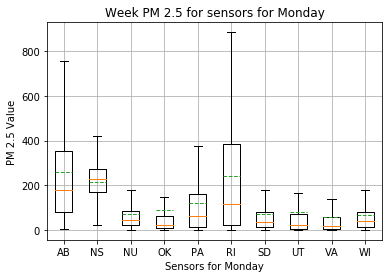

Tuesday - AB list size: 3182
Tuesday - AB list size of data above 1000: 0
Tuesday - NS list size: 15818
Tuesday - NS list size of data above 1000: 0
Tuesday - NU list size: 16901
Tuesday - NU list size of data above 1000: 0
Tuesday - OK list size: 23250
Tuesday - OK list size of data above 1000: 0
Tuesday - PA list size: 24368
Tuesday - PA list size of data above 1000: 0
Tuesday - RI list size: 19602
Tuesday - RI list size of data above 1000: 0
Tuesday - SD list size: 32706
Tuesday - SD list size of data above 1000: 0
Tuesday - UT list size: 18698
Tuesday - UT list size of data above 1000: 0
Tuesday - VA list size: 32095
Tuesday - VA list size of data above 1000: 0
Tuesday - WI list size: 38935
Tuesday - WI list size of data above 1000: 0
Tuesday total: 225555

whiskers:  [7.960824742268041, 453.76701030927836, 0.0, 635.0969072164949, 0.8845360824742268, 170.71546391752577, 0.0, 107.91340206185566, 0.8845360824742268, 372.38969072164946, 0.0, 869.498969072165, 0.0, 218.480412371134, 0.

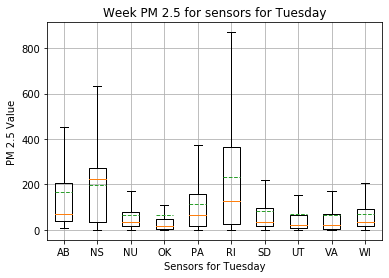

Wednesday - AB list size: 1444
Wednesday - AB list size of data above 1000: 0
Wednesday - NS list size: 13533
Wednesday - NS list size of data above 1000: 0
Wednesday - NU list size: 17437
Wednesday - NU list size of data above 1000: 0
Wednesday - OK list size: 22042
Wednesday - OK list size of data above 1000: 0
Wednesday - PA list size: 24543
Wednesday - PA list size of data above 1000: 0
Wednesday - RI list size: 19652
Wednesday - RI list size of data above 1000: 0
Wednesday - SD list size: 33475
Wednesday - SD list size of data above 1000: 0
Wednesday - UT list size: 18492
Wednesday - UT list size of data above 1000: 0
Wednesday - VA list size: 31939
Wednesday - VA list size of data above 1000: 0
Wednesday - WI list size: 39352
Wednesday - WI list size of data above 1000: 0
Wednesday total: 221909

whiskers:  [0.8845360824742268, 638.6350515463918, 0.0, 616.521649484536, 0.0, 146.83298969072166, 0.0, 86.68453608247422, 0.0, 273.32164948453607, 0.0, 884.5360824742268, 0.0, 219.36494

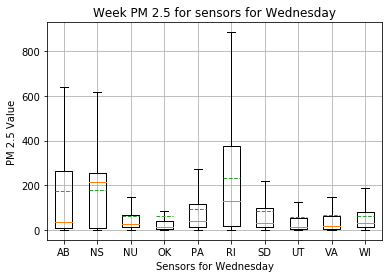

Thursday - AB list size: 1440
Thursday - AB list size of data above 1000: 0
Thursday - NS list size: 13021
Thursday - NS list size of data above 1000: 0
Thursday - NU list size: 16947
Thursday - NU list size of data above 1000: 0
Thursday - OK list size: 21788
Thursday - OK list size of data above 1000: 0
Thursday - PA list size: 24811
Thursday - PA list size of data above 1000: 0
Thursday - RI list size: 19190
Thursday - RI list size of data above 1000: 0
Thursday - SD list size: 34309
Thursday - SD list size of data above 1000: 0
Thursday - UT list size: 18421
Thursday - UT list size of data above 1000: 0
Thursday - VA list size: 32758
Thursday - VA list size of data above 1000: 0
Thursday - WI list size: 39026
Thursday - WI list size of data above 1000: 0
Thursday total: 221711

whiskers:  [15.921649484536083, 464.3814432989691, 0.0, 644.8268041237113, 1.7690721649484535, 173.36907216494845, 0.0, 109.68247422680412, 0.0, 282.16701030927834, 0.8845360824742268, 850.9237113402062, 0.0

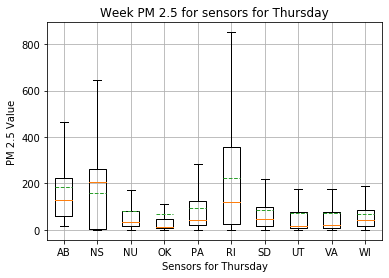

Friday - AB list size: 1791
Friday - AB list size of data above 1000: 0
Friday - NS list size: 10335
Friday - NS list size of data above 1000: 0
Friday - NU list size: 17279
Friday - NU list size of data above 1000: 0
Friday - OK list size: 21419
Friday - OK list size of data above 1000: 0
Friday - PA list size: 24690
Friday - PA list size of data above 1000: 0
Friday - RI list size: 19084
Friday - RI list size of data above 1000: 0
Friday - SD list size: 34442
Friday - SD list size of data above 1000: 0
Friday - UT list size: 18707
Friday - UT list size of data above 1000: 0
Friday - VA list size: 33772
Friday - VA list size of data above 1000: 0
Friday - WI list size: 38873
Friday - WI list size of data above 1000: 0
Friday total: 220392

whiskers:  [16.80618556701031, 884.5360824742268, 0.0, 681.0927835051547, 0.8845360824742268, 191.059793814433, 0.8845360824742268, 130.02680412371134, 0.8845360824742268, 325.50927835051544, 0.8845360824742268, 884.5360824742268, 0.8845360824742268

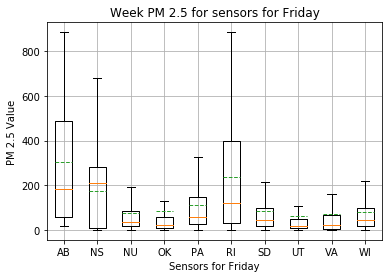

Saturday - AB list size: 2349
Saturday - AB list size of data above 1000: 0
Saturday - NS list size: 10371
Saturday - NS list size of data above 1000: 0
Saturday - NU list size: 16774
Saturday - NU list size of data above 1000: 0
Saturday - OK list size: 23972
Saturday - OK list size of data above 1000: 0
Saturday - PA list size: 25043
Saturday - PA list size of data above 1000: 0
Saturday - RI list size: 20156
Saturday - RI list size of data above 1000: 0
Saturday - SD list size: 34705
Saturday - SD list size of data above 1000: 0
Saturday - UT list size: 18716
Saturday - UT list size of data above 1000: 0
Saturday - VA list size: 33159
Saturday - VA list size of data above 1000: 0
Saturday - WI list size: 38878
Saturday - WI list size of data above 1000: 0
Saturday total: 224123

whiskers:  [11.498969072164948, 424.57731958762884, 92.87628865979381, 444.03711340206183, 2.6536082474226803, 181.3298969072165, 0.8845360824742268, 163.63917525773195, 0.0, 363.5443298969072, 1.76907216494

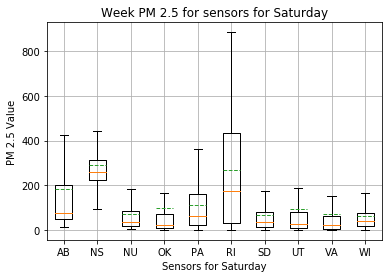

Sunday - AB list size: 1559
Sunday - AB list size of data above 1000: 0
Sunday - NS list size: 13178
Sunday - NS list size of data above 1000: 0
Sunday - NU list size: 14060
Sunday - NU list size of data above 1000: 0
Sunday - OK list size: 25605
Sunday - OK list size of data above 1000: 0
Sunday - PA list size: 25589
Sunday - PA list size of data above 1000: 0
Sunday - RI list size: 19780
Sunday - RI list size of data above 1000: 0
Sunday - SD list size: 34792
Sunday - SD list size of data above 1000: 0
Sunday - UT list size: 18715
Sunday - UT list size of data above 1000: 0
Sunday - VA list size: 34217
Sunday - VA list size of data above 1000: 0
Sunday - WI list size: 38877
Sunday - WI list size of data above 1000: 0
Sunday total: 226372

whiskers:  [9.729896907216494, 398.9257731958763, 84.03092783505154, 500.6474226804124, 0.8845360824742268, 211.4041237113402, 0.8845360824742268, 120.29690721649484, 0.8845360824742268, 395.38762886597937, 0.8845360824742268, 884.5360824742268, 0.0

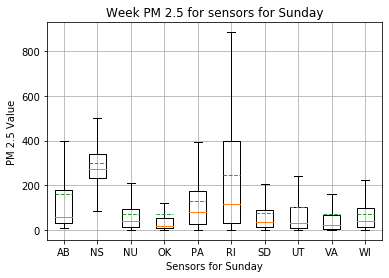

In [7]:
# modified_gers each sensors - This is the working boxplot for modified_gers only Mongolia deployed sensors

plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

all_sensors_names = []
for name, sensor_data in unmodified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = unmodified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = unmodified_gers_data[unmodified_gers_data.index.day_name() == day]
    # temp = temp.groupby("name")
    cumulative = 0
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].dropna().to_numpy().tolist())
        cumulative += len(sensor_data)
        print('{} - {} list size: {}'.format(day, name,  len(sensor_data)))
        print('{} - {} list size of data above 1000: {}'.format(day, name,  len(sensor_data[sensor_data.pm2_5 > 1000])))
    print ('{} total: {}'.format(day, cumulative))    
    print()
    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()
    